In [1]:
its_jupyter_notebook = True

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import copy
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(0, '..')

from util.evaluation import obtain_df_metrics, create_drp_dri_df, obtain_training_info_from_model_name, create_pvalue_df, obtain_enhn_easypos_smartneg, calc_corr_perf_conf, calc_corr_quality_perf, calc_corr_quality_conf, ModelResultsManager, calculate_correlations, balancing_only_for_one_task, obtain_all_model_auc, remove_outliers, map_thermodynamic_columns, obtain_df_auc, replace_outliers_with_nan_and_make_positive, obtain_sr_nosr, map_dataset_to_hp
from util.plot_utils import draw_triangle_with_arrows, plot_sr_distributions_full, plot_correlations_QPC, plot_qualityVSconfidence, plot_metric_confidence_for_all_models_for_2tasks, plot_all_model_auc, perc_neg_npv_precision, collect_results_based_on_topbottom_for_all_models_perc_neg, npv_precision, plot_sr_distributions, plot_tnr_based_on_distance_for_our_model, collect_results_based_on_topbottom_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins, plot_features_vs_risearch2_confidence, plot_heatmap, plot_tnr_recall_for_all_models, plot_correlation_nreads_prob_intsize
from util.model_names_map import map_model_names, map_experiment_names
from util.misc import find_extension_from_savepath


# %load_ext autoreload
# %autoreload 2

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '200_test_tables')

# Set font globally
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7  # Set the default font size

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
model_name = 'arch2_PSORALENtrained_PARISval0074'#'arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0086' #'arch2_PSORALENtrained_PARISval0074' 
PARIS_FINETUNED_MODEL, SPLASH_TRAINED_MODEL = obtain_training_info_from_model_name(model_name)
SPLASH_TRAINED_MODEL = False #anche per i modelli in cui dovrebbe essere true per modelli come arch2_PSORALENtrained_PARISval0074, non c eun vero motivo, ma cambia poco niente
energy_columns = ['IntaRNA', 'priblast', 'RNAplex', 'rnacofold', 'assa', 'RNAhybrid', 'RNAup', 'risearch2']
list_of_HQ_datasets = ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ']
list_of_datasets = list_of_HQ_datasets + ['psoralen', 'paris', 'paris_mouse', 'ricseq', 'mario', 'splash']

In [3]:
nt_models = [model_name]
list_of_models_to_test = ['nt'] + energy_columns + [f'nt{_}' for _ in range(1, len(nt_models))]

In [4]:
modelRM = ModelResultsManager(model_name = 'arch2_PSORALENtrained_PARISval0074', 
                            dimension = 200, 
                            chkpt_directory = os.path.join(ROOT_DIR, 'checkpoints'), 
                            rna_rna_files_dir = rna_rna_files_dir, 
                            test_info_directory = metadata_dir, 
                            other_tools = energy_columns, 
                            other_tools_dir = external_dataset_dir)

### Do the model correlate in their scores?

Sembra esserci una correlazione piu forte con la termodinamica su MOUSE e piu debole su HUMAN

In [5]:
# Set font globally
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7  # Set the default font size

DATASET: psoralen


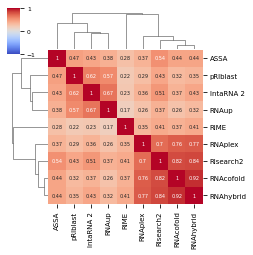

DATASET: ricseq


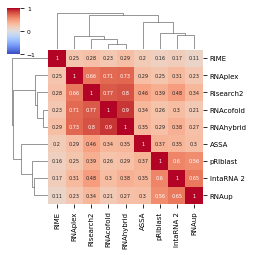

DATASET: mario


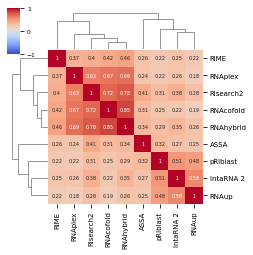

In [11]:
method='spearman' # 'pearson', 'spearman', 'kendall', 'mutual_info'
plot_each_correlation = False

for dataset in ['psoralen', 'ricseq', 'mario']: #psoralen
        
    experiment, specie_paris, _, _, _, _, _, _ = map_dataset_to_hp(dataset)
        
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = 1,
        n_reads_mario = 1,
        logistic_regression_models = {},
    )

    for model_column in energy_columns:
        res[model_column] = -res[model_column] # make energy column positives, such that the correlations will be positives as well


    #res_for_corr = balancing_only_for_one_task(res, task = 'all')
    
    res_for_corr = res[res.ground_truth == 1]
    
    print(f'DATASET: {dataset}')
    
    figsize = (3.5, 3.5) if dataset=='psoralen' else (3.5, 3.5)
     
    #correlations = calculate_correlations([res_for_corr[i] for i in energy_columns + ['probability'] + [f'nt{_}' for _ in range(1, len(nt_models))]], method=method, plot=plot_each_correlation)
    correlations = calculate_correlations([res_for_corr[i] for i in ['probability'] + energy_columns + [f'nt{_}' for _ in range(1, len(nt_models))]], method=method, plot=plot_each_correlation)
    plot_heatmap(correlations, highlight_labels = map_model_names(energy_columns), method = method, figsize=figsize, numbers_size = 5, savepath = os.path.join(plots_dir, f'correlation_heatmap_{dataset}.pdf'))

### Checks 

In [6]:
# for exp in ['test_HQ', 'test', 'mario', 'splash', 'ricseq',]:
    
#     if exp == 'test_HQ':
#         experiment = 'paris'
#         paris_hq = True
    
#     elif exp == 'test':
#         experiment = 'paris'
#         paris_hq = False
#     else:
#         experiment = exp
#         paris_hq = False
        
        
#     res = modelRM.get_experiment_data(
#                 experiment = experiment, 
#                 paris_test = True, 
#                 paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#                 specie_paris = 'all',
#                 paris_hq = paris_hq,
#                 paris_hq_threshold = 1,
#                 n_reads_paris = 1,
#                 interlen_OR_nreads_paris = False,
#                 splash_trained_model = False,
#                 only_test_splash_ricseq_mario = False,
#                 n_reads_ricseq = 1,
#                 n_reads_mario = 1,
#                 logistic_regression_models = {},
#     ) 
        
#     original_res = pd.read_csv( os.path.join(ROOT_DIR, 'checkpoints', model_name, f'{exp}_results200.csv'))
#     test500 = pd.read_csv(os.path.join(metadata_dir, f'{exp}200.csv'))
    
    
#     print(exp)
    
#     with open(os.path.join(rna_rna_files_dir, "gene_pairs_training.txt"), "rb") as fp:
#             couples_paris_training = pickle.load(fp)
#     original_res = original_res[~original_res.couples.isin(couples_paris_training)].reset_index(drop = True)
#     test500 = test500[~(test500.g1 + '_' + test500.g2).isin(couples_paris_training)].reset_index(drop = True)
    
#     assert test500.shape[0] == original_res.shape[0]
#     assert set(test500.couples) == set(original_res.id_sample) == set(res.id_sample)
#     assert set(original_res.merge(res, on = ['probability', 'id_sample']).id_sample) == set(original_res.id_sample)

#     cols_equal = list(set(test500.drop(['policy', 'g1', 'g2', 'couples'], axis = 1).columns).intersection(res.columns))
#     assert set(test500.merge(res.drop('couples', axis = 1), on = cols_equal).couples) == set(original_res.id_sample)

# Map models signal in [0, 1] and save the mapping

##### Train the model (we train with psoralen human)

In [7]:
res = modelRM.get_experiment_data(
    experiment = 'paris', 
    paris_test = True, 
    paris_finetuned_model = PARIS_FINETUNED_MODEL, 
    specie_paris = 'all',
    paris_hq = False,
    paris_hq_threshold = 1,
    n_reads_paris = 1,
    interlen_OR_nreads_paris = False,
    splash_trained_model = False,
    only_test_splash_ricseq_mario = False,
    n_reads_ricseq = np.nan,
    n_reads_mario = np.nan,
    logistic_regression_models = {},
)

In [6]:
df_training = balancing_only_for_one_task(res, task = 'all').reset_index(drop = True)

In [100]:
logistic_regression_models = {}
for model_column in tqdm(energy_columns):
    
    
    df_s = df_training.copy()
    df_s = remove_outliers(df_s, model_column, threshold = 3)
    df_training = balancing_only_for_one_task(df_training, task = 'all').reset_index(drop = True)
    
    X_train, y_train = np.expand_dims(df_s[model_column], 1), np.array(df_s.ground_truth)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Calculate threshold_value
    threshold_value = -model.intercept_ / model.coef_
    threshold_value = np.round(threshold_value[0][0], 2)

    logistic_regression_models[model_column] = {'intercept': model.intercept_[0], 
                                               'coef': model.coef_[0][0],
                                               'threshold_value': threshold_value}
    
    
#assa
logistic_regression_models['assa']['threshold_value'] = -0.05 # 
logistic_regression_models['assa']['coef'] = np.round(-logistic_regression_models['assa']['intercept'] / logistic_regression_models['assa']['coef'], 2)

#priblast
logistic_regression_models['priblast']['threshold_value'] = -0.05 # 
logistic_regression_models['priblast']['coef'] = np.round(-logistic_regression_models['priblast']['intercept'] / logistic_regression_models['priblast']['coef'], 2)


# # Open the file in binary write mode and serialize the dictionary
# with open(LR_MAPPING_PATH, 'wb') as file:
#     pickle.dump(logistic_regression_models, file)

  0%|          | 0/8 [00:00<?, ?it/s]

# Model comparison

In [5]:
with open(LR_MAPPING_PATH, 'rb') as file:
    logistic_regression_models = pickle.load(file)

### AUC

In [6]:
df_auc = obtain_df_auc(modelRM, PARIS_FINETUNED_MODEL, energy_columns, SPLASH_TRAINED_MODEL, list_of_datasets = list_of_datasets, logistic_regression_models = {} )

HQ_COLS = [
    'model_name', 
    'auc_DRI_parisHQ', 'auc_DRP_parisHQ', 
    'auc_DRI_paris_mouse_HQ', 'auc_DRP_paris_mouse_HQ',
    'auc_DRI_ricseqHQ', 'auc_DRP_ricseqHQ'
]

SE_HQ_COLS = [
    'model_name', 
    'se_DRI_parisHQ', 'se_DRP_parisHQ', 
    'se_DRI_paris_mouse_HQ', 'se_DRP_paris_mouse_HQ',
    'se_DRI_ricseqHQ', 'se_DRP_ricseqHQ'
]

OTHER = [
    'model_name', 
    'auc_DRI_psoralen', 'auc_DRP_psoralen', 
    'auc_DRI_paris', 'auc_DRP_paris', 
    'auc_DRI_paris_mouse', 'auc_DRP_paris_mouse', 
    'auc_DRI_ricseq', 'auc_DRP_ricseq', 'auc_DRI_mario', 
    'auc_DRP_mario', 'auc_DRI_splash', 'auc_DRP_splash'
]

  0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
df_auc.filter(HQ_COLS, axis = 1)

,model_name,auc_DRI_parisHQ,auc_DRP_parisHQ,auc_DRI_paris_mouse_HQ,auc_DRP_paris_mouse_HQ,auc_DRI_ricseqHQ,auc_DRP_ricseqHQ
0,RIME,0.7208,0.7756,0.6240,0.7641,0.6955,0.7709
1,IntaRNA 2,0.5678,0.5953,0.5864,0.6246,0.5368,0.5791
2,pRIblast,0.5512,0.5719,0.5695,0.5979,0.5344,0.5591
3,RNAplex,0.5408,0.5746,0.6081,0.6799,0.5692,0.6124
4,RNAcofold,0.5068,0.5417,0.5516,0.6397,0.5500,0.5906
5,ASSA,0.5364,0.5531,0.5613,0.5909,0.5677,0.5834
6,RNAhybrid,0.5498,0.5894,0.6002,0.6810,0.6077,0.6552
7,RNAup,0.5504,0.5733,0.5774,0.6034,0.4923,0.5316
8,RIsearch2,0.5811,0.6249,0.6243,0.7006,0.6157,0.6658


In [8]:
df_auc.filter(OTHER, axis = 1)

,model_name,auc_DRI_psoralen,auc_DRP_psoralen,auc_DRI_paris,auc_DRP_paris,auc_DRI_paris_mouse,auc_DRP_paris_mouse,auc_DRI_ricseq,auc_DRP_ricseq,auc_DRI_mario,auc_DRP_mario,auc_DRI_splash,auc_DRP_splash
0,RIME,0.5820,0.6835,0.5756,0.6739,0.5422,0.6945,0.5438,0.6315,0.4981,0.6665,0.6761,0.8265
1,IntaRNA 2,0.5493,0.5867,0.5337,0.5694,0.5474,0.5906,0.5752,0.6127,0.4768,0.5477,0.7977,0.8645
2,pRIblast,0.5370,0.5652,0.5225,0.5488,0.5280,0.5621,0.5529,0.5756,0.5000,0.5290,0.7634,0.8166
3,RNAplex,0.5260,0.5732,0.5253,0.5708,0.5278,0.6036,0.5106,0.5600,0.5096,0.6415,0.5262,0.6039
4,RNAcofold,0.5192,0.5703,0.5154,0.5659,0.5181,0.6057,0.4962,0.5388,0.5001,0.6740,0.5695,0.6314
5,ASSA,0.5304,0.5551,0.5168,0.5404,0.5209,0.5538,0.5353,0.5471,0.4991,0.5273,0.7423,0.7810
6,RNAhybrid,0.5325,0.5860,0.5281,0.5805,0.5279,0.6138,0.5172,0.5725,0.5045,0.6655,0.5906,0.6685
7,RNAup,0.5394,0.5683,0.5250,0.5522,0.5353,0.5642,0.5607,0.5951,0.4838,0.5381,0.7677,0.8157
8,RIsearch2,0.5456,0.6046,0.5351,0.5930,0.5379,0.6226,0.5478,0.6010,0.4993,0.6371,0.7158,0.7944


dataset: parisHQ
# of positive samples:  424


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


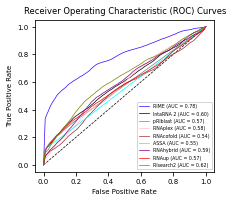

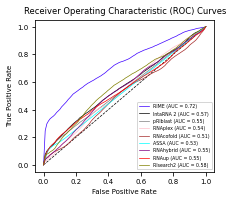

dataset: paris_mouse_HQ
# of positive samples:  82


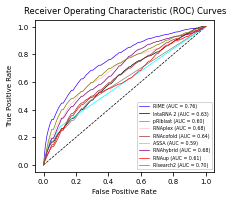

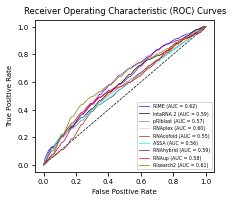

dataset: ricseqHQ
# of positive samples:  161


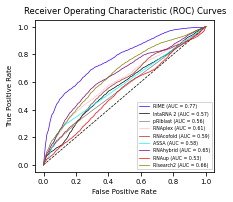

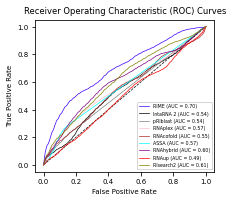

In [8]:
for dataset in list_of_HQ_datasets:
    
    experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_mario, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = paris_test, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = paris_hq_threshold,
        n_reads_paris = n_reads_paris,
        interlen_OR_nreads_paris = interlen_OR_nreads_paris,
        splash_trained_model = SPLASH_TRAINED_MODEL,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        n_reads_mario = n_reads_mario,
        logistic_regression_models = logistic_regression_models,
    )
     
    print(f'dataset: {dataset}')
    print('# of positive samples: ', res[res.policy=='easypos'].shape[0])
    
    plot_all_model_auc(res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True), energy_columns, linewidth=0.7, legend_fontsize=4.7, figsize=(3.2, 2.8), savepath = os.path.join(plots_dir, f'AUC_DRP_{dataset}.pdf'))
    plot_all_model_auc(res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True), energy_columns, linewidth=0.7, legend_fontsize=4.7, figsize=(3.2, 2.8), savepath = os.path.join(plots_dir, f'AUC_DRI_{dataset}.pdf'))

In [10]:
# TO CHECK THAT IT'S WORKING THE MAPPING
# df_auc2 = obtain_df_auc(modelRM, energy_columns, list_of_datasets = list_of_datasets, logistic_regression_models = logistic_regression_models )
# errors = df_auc.filter(OTHER, axis = 1).drop('model_name', axis =1 ) - df_auc2.filter(OTHER, axis = 1).drop('model_name', axis =1 )
# errors['model_name'] = df_auc['model_name']
# errors

### Repeats enrichment

In [6]:
#analysis args
feature_to_search_name = 'Simple Repeat' #'Simple_repeat', 'Low_complexity'
list_of_feature_to_search = ['Simple_repeat', 'Low_complexity']


full_overlap = False
if full_overlap:
    suffix = 'full_'
else:
    suffix = ''
    
both_sr_condition = True

In [7]:
#kde plot args
figsize_rime_plot = (4.5, 2.1)
figsize_thermodynamic_plot = (6, 1.9)

#treshold plot args
figsize_treshold = (17,9)
MIN_PERC = 2
n_values = 12
size_multiplier = 0
n_run_undersampling = 15
list_of_metrics = ['precision_recall_curve']
plot_function = plot_results_based_on_topbottom_for_all_models

##############   ##############   ##############   ##############   ##############
---------- DATASET: psoralen ----------
Simple Repeat (BOTH) are the 1.3583001843407394  % of the total couples
Simple Repeat (AT LEAST ONE) are the 19.03237282106012  % of the total couples
No Simple Repeat are the 81.97341612496362  % of the total couples


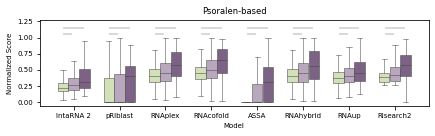




##############   ##############   ##############   ##############   ##############
---------- DATASET: ricseq ----------
Simple Repeat (BOTH) are the 0.7002471460515476  % of the total couples
Simple Repeat (AT LEAST ONE) are the 14.599270330704956  % of the total couples
No Simple Repeat are the 85.40072966929505  % of the total couples


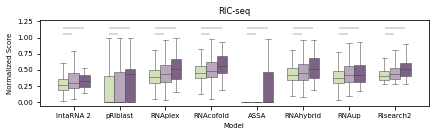




##############   ##############   ##############   ##############   ##############
---------- DATASET: mario ----------
Simple Repeat (BOTH) are the 0.37533512064343166  % of the total couples
Simple Repeat (AT LEAST ONE) are the 14.638069705093834  % of the total couples
No Simple Repeat are the 85.36193029490616  % of the total couples


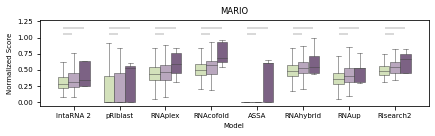

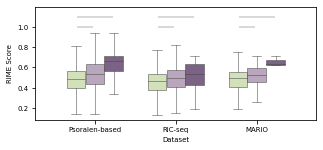

In [29]:
df_sr_only_rime = []
pvalue_df_list = []

for dataset in ['psoralen', 'ricseq', 'mario']: #'paris_mouse',
    print(f'##############   ##############   ##############   ##############   ##############')
    print(f'---------- DATASET: {dataset} ----------')
    
    
    experiment, specie_paris, _, _, _, _, _, _ = map_dataset_to_hp(dataset)
        
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = 1,
        n_reads_mario = 1,
        logistic_regression_models = {},
    )
    
    res = replace_outliers_with_nan_and_make_positive(res, energy_columns)
    
    #normalize after we removed outliers
    for model_column in energy_columns:
        res[model_column] = (res[model_column]-res[model_column].min())/(res[model_column].max()-res[model_column].min())
    
    res['simple_repeat1'] = res[f'{suffix}feature1'].apply(lambda x: any(f in x for f in list_of_feature_to_search))
    res['simple_repeat2'] = res[f'{suffix}feature2'].apply(lambda x: any(f in x for f in list_of_feature_to_search))
    res['none1'] = res[f'{suffix}feature1'].apply(lambda x: 'None' in x)
    res['none2'] = res[f'{suffix}feature2'].apply(lambda x: 'None' in x)
    
    filtered_policies = ['easypos', 'smartneg']
    sr_both, no_sr = obtain_sr_nosr(res, True, filtered_policies)
    sr_one, _ = obtain_sr_nosr(res, False, filtered_policies)
    N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))
    print(f'{feature_to_search_name} (BOTH) are the {len(set(sr_both.id_sample)) /  N_total_couples * 100}  % of the total couples')
    print(f'{feature_to_search_name} (AT LEAST ONE) are the {len(set(sr_one.id_sample)) /  N_total_couples * 100}  % of the total couples')
    print(f'No {feature_to_search_name} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')

    if len(set(sr_both.id_sample))>0:

        sr2_ep = sr_both[sr_both.policy == 'easypos'].reset_index(drop = True)
        sr2_sn = sr_both[sr_both.policy == 'smartneg'].reset_index(drop = True)
        
        sr1_ep = sr_one[sr_one.policy == 'easypos'].reset_index(drop = True)
        sr1_sn = sr_one[sr_one.policy == 'smartneg'].reset_index(drop = True)

        no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
        no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)


        df_sr = []
        for column in (['probability'] + energy_columns):

            x2, x1, y = sr2_ep[column], sr1_ep[column], no_sr_ep[column]

            x2_clean = x2[~np.isnan(x2)].reset_index(drop = True)
            x1_clean = x1[~np.isnan(x1)].reset_index(drop = True)
            y_clean = y[~np.isnan(y)].reset_index(drop = True)
            
            # if (dataset=='ricseq') & (column== 'assa'):
            #     print(np.mean(y_clean), np.median(y_clean), np.percentile(y_clean, 90))
            #     print(np.mean(x1_clean), np.median(x1_clean), np.percentile(x1_clean, 90))
            #     print(stats.mannwhitneyu(x1_clean, y_clean, alternative='two-sided'))
            #     sns.kdeplot(x1_clean, label='x1', fill=False, alpha=0.5)
            #     sns.kdeplot(y_clean, label='y', fill=False, alpha=0.5)
            #     plt.legend()
            #     plt.show()

            pvalue_df_list.append({'dataset':dataset, 'column':column, 'both': stats.mannwhitneyu(x2_clean, y_clean, alternative='two-sided')[1], 'at_least_one': stats.mannwhitneyu(x1_clean, y_clean, alternative='two-sided')[1]})
            
            df_model = pd.DataFrame({
                    'Model': [column] * (len(x2_clean) + len(x1_clean) + len(y_clean)),
                    'Category': pd.concat([
                        pd.Series([f'both {feature_to_search_name} positive samples'] * len(x2_clean)), 
                        pd.Series([f'at least {feature_to_search_name} positive samples'] * len(x1_clean)), 
                        pd.Series([f'no {feature_to_search_name} positive samples'] * len(y_clean))
                    ]),
                    'Normalized Score': pd.concat([x2_clean, x1_clean, y_clean])
            })

            df_sr.append(df_model)

            if column == 'probability':
                df_model = df_model.copy()
                df_model['Dataset'] = dataset
                df_sr_only_rime.append(df_model)

        df_sr = pd.concat(df_sr)

        df_sr = df_sr[~(df_sr.Model == 'probability')].reset_index(drop = True) #only_thermodynamics
        
        both_sr = 'both_sr' if both_sr_condition else 'one_sr'
        plot_sr_distributions_full(df_sr, label_x = 'Model', label_x_name = 'Model',
                                   figsize = figsize_thermodynamic_plot,
                                   title = map_experiment_names(dataset),
                                   savepath = os.path.join(plots_dir, f'{feature_to_search_name}_{suffix}_{dataset}_thermodynamics.pdf'))
        
        
        # if both_sr_condition:
        #     label_x = f'both {feature_to_search_name} positive samples'
        # else:
        #     label_x = f'at least {feature_to_search_name} positive samples'
        # both_sr = 'both_sr' if both_sr_condition else 'one_sr'
        # plot_sr_distributions(df_sr[df_sr['Category'].isin([label_x, 'no Simple Repeat positive samples'])].reset_index(drop=True),
        #                       label_x, figsize = figsize_treshold, 
        #                       savepath = os.path.join(plots_dir, f'{feature_to_search_name}_{suffix}_{both_sr}_{dataset}_thermodynamics.pdf'))

        print('\n\n')
    
df_sr_only_rime = pd.concat(df_sr_only_rime)
plot_sr_distributions_full(df_sr_only_rime, label_y_name = 'RIME Score', title = '', figsize = figsize_rime_plot, savepath = os.path.join(plots_dir, f'{feature_to_search_name}_{suffix}_{MODEL_NAME}_alldatasets.pdf'))


pvalue_df = create_pvalue_df(pvalue_df_list)
# plot_sr_distributions(df_sr_only_rime[df_sr_only_rime['Category'].isin([label_x, 'no Simple Repeat positive samples'])].reset_index(drop=True),
#                       label_x, label_y_name = 'RIME score', 
#                       column = 'Dataset', figsize = figsize_treshold, savepath = os.path.join(plots_dir, f'{feature_to_search_name}_{suffix}_{both_sr}_{MODEL_NAME}_alldatasets.pdf'))

In [28]:
pvalue_df.head(2)

,dataset,column,both,at_least_one,both_bh,at_least_one_bh,sig_both,sig_at_least_one,ast_at_least_one_bh,ast_both_bh
0,psoralen,probability,6.880469e-58,9.229192e-66,9.288633e-57,1.245941e-64,True,True,4,4
1,psoralen,IntaRNA,2.703544e-22,9.344667e-51,1.042796e-21,5.046120e-50,True,True,4,4


### To see how it works in predicting Simple Repeat cases, but also whats the percentage of SR at high confidence

In [58]:
# for dataset in list_of_datasets:
#     print(f'##############   ##############   ##############   ##############   ##############')
#     print(f'---------- DATASET: {dataset} ----------')

#     experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_mario, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
        
#     res = modelRM.get_experiment_data(
#         experiment = experiment, 
#         paris_test = paris_test, 
#         paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#         specie_paris = specie_paris,
#         paris_hq = paris_hq_threshold,
#         paris_hq_threshold = 1,
#         n_reads_paris = n_reads_paris,
#         interlen_OR_nreads_paris = False,
#         splash_trained_model = False,
#         only_test_splash_ricseq_mario = False,
#         n_reads_ricseq = n_reads_ricseq,
#         n_reads_mario = n_reads_mario,
#         logistic_regression_models = logistic_regression_models,
#     )

#     res['simple_repeat1'] = res[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)
#     res['simple_repeat2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)
#     res['none1'] = res[f'{suffix}feature1'].apply(lambda x: 'None' in x)
#     res['none2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)

#     filtered_policies = ['easypos', 'smartneg']
#     sr, no_sr = obtain_sr_nosr(res, both_sr_condition, filtered_policies)
#     N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))
#     print(f'{feature_to_search} are the {len(set(sr.id_sample)) /  N_total_couples * 100}  % of the total couples')
#     print(f'No {feature_to_search} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')

#     sr_ep = sr[sr.policy == 'easypos'].reset_index(drop = True)
#     sr_sn = sr[sr.policy == 'smartneg'].reset_index(drop = True)

#     no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
#     no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)

#     ##################### ##################### TRESHOLD PLOTS ##################### #####################
        
#     for metric in list_of_metrics:
    
#         for task in tasks_treshold:
#             print(f'           -- -- -- {task} -- -- -- ')
#             print(f'           -  -  -  {metric}  -  -  - ')

#             if task == 'simple_repeat_EPSN':
#                 assert len(sr.ground_truth.value_counts().index) == 2
#                 subset_to_plot = sr.reset_index(drop = True)
#             elif task == 'no_simple_repeat_EPSN':
#                 assert len(no_sr.ground_truth.value_counts().index) == 2
#                 subset_to_plot = no_sr.reset_index(drop = True)

#             plt.figure(figsize=figsize_treshold)
#             plot_function(subset_to_plot, MIN_PERC = MIN_PERC, 
#                           list_of_models_to_test = ['probability'] + energy_columns, 
#                           n_values = n_values, n_run_undersampling = n_run_undersampling, 
#                           metric = metric, task_name = task, 
#                           size_multiplier = size_multiplier#, balance_predictions_at_each_step = True
#                          )
#             plt.show()
            
#     print('\n\n')
    
#     ##################### ##################### REPEATS IN POSITIVE PREDICTIONS ##################### #####################
#     #Percentage of SR in positive predictions based on model Confidence Levels (questo prende in considerazione tutti i positivi, e vediamo se all aumentare del livello di confidenza predilige le repeats)
#     print('EASYPOS Percentage of SR in positive predictions based on model Confidence Levels')
#     plt.figure(figsize=figsize_treshold)
#     plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'easypos'].reset_index(drop = True),
#                                                              MIN_PERC, ['probability'] + energy_columns, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
#                                                             )
#     print('SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels')
#     plt.figure(figsize=figsize_treshold)
#     plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'smartneg'].reset_index(drop = True),
#                                                              MIN_PERC, ['probability'] + energy_columns, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
#                                                             ) #these are errors
    
    
#     print('\n\n')

### Patches task depend on the distance from the interaction site, and on the presence of interacting regions inside the embedding

A notable feature of our method is its growing confidence in predicting negatives as the distance to interaction regions in the embeddings increases. Essentially, the model's confidence and its ability to accurately identify HNW and ENW improve when interaction regions are more distant within the embeddings.

In [17]:
# figsize = (17, 9)
# size_multiplier = 20
# bins_distance = [[1, 250], [250, 500], [500, 1_000], [1_000, 1_500], [1_500, 2_500], [2_500, 5_000], [5_000, 100_000]]

# checkpoint_dir = [os.path.join(ROOT_DIR, 'checkpoints', _) for _ in nt_models]

# for dataset in list_of_datasets:
    
#     print(f'---------- DATASET: {dataset} ----------')
    
#     experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_mario, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    
#     res = modelRM.get_experiment_data(
#         experiment = experiment, 
#         paris_test = paris_test, 
#         paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#         specie_paris = specie_paris,
#         paris_hq = False,
#         paris_hq_threshold = paris_hq_threshold,
#         n_reads_paris = n_reads_paris,
#         interlen_OR_nreads_paris = False,
#         splash_trained_model = False,
#         only_test_splash_ricseq_mario = False,
#         n_reads_ricseq = n_reads_ricseq,
#         n_reads_mario = n_reads_mario,
#         logistic_regression_models = logistic_regression_models,
#     )
        
#     subset_to_plot = res[res.policy.isin(['easyneg', 'hardneg'])].reset_index(drop = True)
    
    
#     plot_tnr_for_all_models(list_of_models_to_test, #['nt']
#                             subset_to_plot, 
#                             figsize = figsize, 
#                             title_suffix = f'dataset: {dataset}', 
#                             bar_width = 0.5
#                            )

#     plot_tnr_based_on_distance_for_all_models(subset_to_plot,
#                                               bins_distance,
#                                               list_of_models_to_test, #['nt']
#                                               figsize=figsize, 
#                                               size_multiplier = size_multiplier
#                                              )

#     bins_distance_quantile = quantile_bins(subset_to_plot.distance_from_site, 10)
#     plot_confidence_based_on_distance_for_all_models(subset_to_plot, 
#                                                      bins_distance_quantile, 
#                                                      list_of_models_to_test, #['nt']
#                                                      figsize)

### Plots based on top-bottom

In [6]:
#plot parameters
n_values = 5
figsize = (3.5,1.5)
size_multiplier = 10

MIN_PERC = 5
list_of_metrics = ['precision', 'npv'] #['f1','precision', 'npv'] #[['f1','precision', 'npv', 'recall', 'specificity', 'precision_recall_curve']
balance_predictions_at_each_step=False

#### Patches / Intectors

In [19]:
# for dataset in list_of_datasets:
    
#     experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_mario, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    
#     if dataset in ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ', 'mario', 'splash']:
#         n_run_undersampling = 50 
#     else:
#         n_run_undersampling = 10
    
#     res = modelRM.get_experiment_data(
#         experiment = experiment, 
#         paris_test = paris_test, 
#         paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#         specie_paris = specie_paris,
#         paris_hq = False,
#         paris_hq_threshold = paris_hq_threshold,
#         n_reads_paris = n_reads_paris,
#         interlen_OR_nreads_paris = False,
#         splash_trained_model = False,
#         only_test_splash_ricseq_mario = False,
#         n_reads_ricseq = n_reads_ricseq,
#         n_reads_mario = n_reads_mario,
#         logistic_regression_models = logistic_regression_models,
#     )
    
#     easypos_smartneg = res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True)
#     ephnen = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True)
    
#     #interactors
#     print(dataset, 'interactors')
#     precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
#     npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
#     npv_data = np.array([npv [::-1] for npv in npv_models])
#     npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRI_{dataset}.pdf'))
    
#     #patches
#     print(dataset, 'patches')
#     precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
#     npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
#     npv_data = np.array([npv [::-1] for npv in npv_models])
#     npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRP_{dataset}.pdf'))
    
#     plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'interactors'), figsize, bar_width=0.35)
#     plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'patches'), figsize, bar_width=0.35)

#### Merging patches and interactors

In [20]:
# for dataset in list_of_datasets:
    
#     experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_mario, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    
#     if dataset in ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ', 'mario', 'splash']:
#         n_run_undersampling = 50 
#     else:
#         n_run_undersampling = 10
    
#     res = modelRM.get_experiment_data(
#         experiment = experiment, 
#         paris_test = paris_test, 
#         paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#         specie_paris = specie_paris,
#         paris_hq = paris_hq_threshold,
#         paris_hq_threshold = 1,
#         n_reads_paris = n_reads_paris,
#         interlen_OR_nreads_paris = False,
#         splash_trained_model = False,
#         only_test_splash_ricseq_mario = False,
#         n_reads_ricseq = n_reads_ricseq,
#         n_reads_mario = n_reads_mario,
#         logistic_regression_models = logistic_regression_models,
#     )
    
#     print(f'dataset: {dataset}')
    
#     precision_data, _, model_names, perc_sn_prec, perc_hn_prec, perc_en_prec = collect_results_based_on_topbottom_for_all_models_perc_neg(res, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
#     npv_models, _, model_names, perc_sn_npv, perc_hn_npv, perc_en_npv = collect_results_based_on_topbottom_for_all_models_perc_neg(res, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
    
#     npv_data = np.array([npv [::-1] for npv in npv_models])
#     perc_sn_npv = np.array([npv [::-1] for npv in perc_sn_npv])
#     perc_hn_npv = np.array([npv [::-1] for npv in perc_hn_npv])
#     perc_en_npv = np.array([npv [::-1] for npv in perc_en_npv])
    
#     npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC)     
#     perc_neg_npv_precision(perc_sn_prec, perc_hn_prec, perc_en_prec, perc_sn_npv, perc_hn_npv, perc_en_npv, model_names, 'nt', figsize, min_perc = 1)
#     plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'all'), figsize, bar_width=0.35)

### 1 plot only RIME 

In [7]:
shorter_datasets = ['psoralen', 'ricseq', 'mario']

prec_dri_list = []
npv_dri_list = []
prec_drp_list = []
npv_drp_list = []

for dataset in shorter_datasets:
    
    experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_mario, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    
    if dataset in ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ', 'mario', 'splash']:
        n_run_undersampling = 50 
    else:
        n_run_undersampling = 10
    
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = paris_test, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = paris_hq_threshold,
        n_reads_paris = n_reads_paris,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        n_reads_mario = n_reads_mario,
        logistic_regression_models = logistic_regression_models,
    )
    
    easypos_smartneg = res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True)
    ephnen = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True)
    
    #interactors
    print(dataset, 'interactors')
    precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, ['nt'], n_values, n_run_undersampling, 'precision')
    npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, ['nt'], n_values, n_run_undersampling, 'npv')
    prec_dri_list.append(precision_data[0])
    npv_dri_list.append(npv_models[0])
    npv_data = np.array([npv [::-1] for npv in npv_models])
    
    #patches
    print(dataset, 'patches')
    precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, ['nt'], n_values, n_run_undersampling, 'precision')
    npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, ['nt'], n_values, n_run_undersampling, 'npv')
    prec_drp_list.append(precision_data[0])
    npv_drp_list.append(npv_models[0])
    npv_data = np.array([npv [::-1] for npv in npv_models])
    
    
# npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRI_{dataset}.pdf'))
# npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRP_{dataset}.pdf'))

# plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'interactors'), figsize, bar_width=0.35)
# plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'patches'), figsize, bar_width=0.35)

psoralen interactors
psoralen patches
ricseq interactors
ricseq patches
mario interactors
mario patches


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


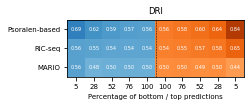

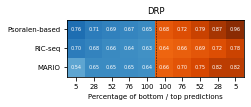

In [8]:
npv_precision(np.array(prec_dri_list), np.array([npv [::-1] for npv in npv_dri_list]), shorter_datasets, figsize, MIN_PERC, title = 'DRI', savepath = os.path.join(plots_dir, f'derbyplot_DRI_RIME.pdf'), plot_legend = False)
npv_precision(np.array(prec_drp_list), np.array([npv [::-1] for npv in npv_drp_list]), shorter_datasets, figsize, MIN_PERC, title = 'DRP', savepath = os.path.join(plots_dir, f'derbyplot_DRP_RIME.pdf'), plot_legend = False)

In [49]:
corr_perf_conf = calc_corr_perf_conf(prec_dri_list, npv_dri_list, prec_drp_list, npv_drp_list, shorter_datasets)

# Ricseq AUC increase with higher n_reads

In [9]:
filter_neg_by_HQ = False

In [10]:
dfs = []

n_positives_run = []

pos_score = []

list_of_n_reads_ricseq = [2,3,4,5,6,7,8] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20] #[2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20]

for n_reads_ricseq in list_of_n_reads_ricseq:
    
    res = modelRM.get_experiment_data(
        experiment = 'ricseq', 
        paris_test = np.nan, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = np.nan,
        paris_hq = np.nan,
        paris_hq_threshold = np.nan,
        n_reads_paris = np.nan,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        n_reads_mario = np.nan,
        logistic_regression_models = {},
    )
    
    enhn, easypos_smartneg = obtain_enhn_easypos_smartneg(res, filter_neg_by_HQ = filter_neg_by_HQ)
    
    pos = res[res.policy == 'easypos'].reset_index(drop = True)
    
    print(f'# total positive samples for N_reads >= {n_reads_ricseq}: \n {res[(res.ground_truth == 1)].shape[0]}')
    
    n_positives_run.append(pos.shape[0])
    
    pos_score.append(list(pos.probability))
    
    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_DRI_ricseq_nread{n_reads_ricseq}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_DRP_ricseq_nread{n_reads_ricseq}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

# total positive samples for N_reads >= 2: 
 8991
# total positive samples for N_reads >= 3: 
 855
# total positive samples for N_reads >= 4: 
 162
# total positive samples for N_reads >= 5: 
 73
# total positive samples for N_reads >= 6: 
 41
# total positive samples for N_reads >= 7: 
 23
# total positive samples for N_reads >= 8: 
 17


In [8]:
# Calculate rho quality VS performance
corr_ricseq_quality_perf = calc_corr_quality_perf(df_auc, 'ricseq_nread', list_of_n_reads_ricseq, corr = 'pearson')
corr_ricseq_quality_perf

,DRI_AUC,DRP_AUC,ricseq_nread
DRI_AUC,1.000000,0.997546,0.884212
DRP_AUC,0.997546,1.000000,0.856455
ricseq_nread,0.884212,0.856455,1.000000


In [9]:
# Calculate rho quality VS confidence
corr_ricseq_quality_confidence = calc_corr_quality_conf(pos_score, 'ricseq_nread', list_of_n_reads_ricseq, 'pearson')
corr_ricseq_quality_confidence

,mean_pos_score,ricseq_nread
mean_pos_score,1.000000,0.797365
ricseq_nread,0.797365,1.000000


#### Plot

TASK:  interactors


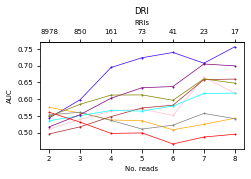




TASK:  patches


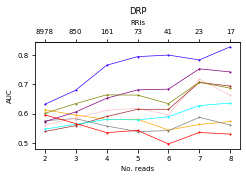

In [16]:
plot_metric_confidence_for_all_models_for_2tasks(df_auc, list_of_n_reads_ricseq, n_positives_run, 'ricseq_nread', linewidth = 0.7, size_multiplier = 0, titles = ['DRI', 'DRP'], xlabel = 'No. reads', ylabel = 'AUC', legend_fontsize = 0, figsize = (3.5, 2.5), savepath = os.path.join(plots_dir, 'quality_performance_ricseq.pdf'))

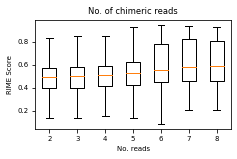

In [23]:
plot_qualityVSconfidence(list_of_n_reads_ricseq, pos_score, title = 'No. of chimeric reads', xlabel='No. reads', figsize = (3.5, 2), savepath =  os.path.join(plots_dir, f'confidence_quality_ricseq.pdf'))

# PARIS HQ

Correlation between log(interaction size) and n_reads: 0.16
Correlation between log(interaction size) and probability: 0.12
Correlation between n_reads and probability: 0.03


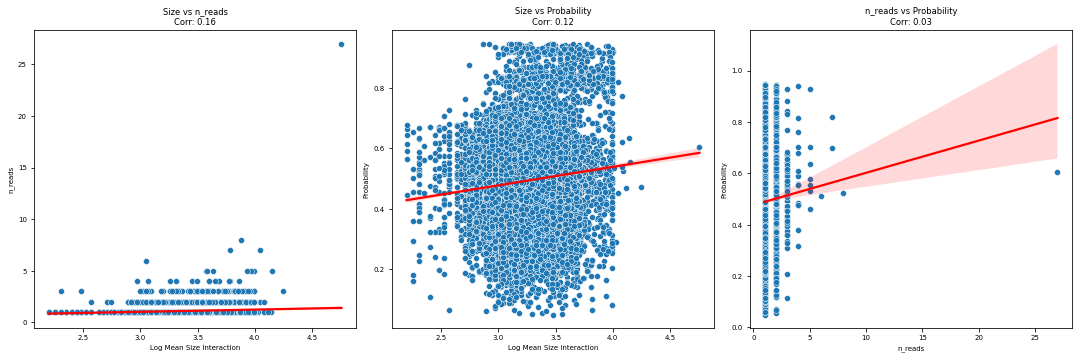

In [11]:
filter_neg_by_HQ = False

plot_correlation_nreads_prob_intsize(modelRM, PARIS_FINETUNED_MODEL)

### Paris AUC increase with higher n_reads

In [12]:
SPECIE = 'all'

dfs = []

n_positives_run = []
pos_score = []

list_of_n_reads_paris = [1,2,3,4,5] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20] #[2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20]

for n_reads_paris in list_of_n_reads_paris:
    
    res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL,
        specie_paris = SPECIE,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = n_reads_paris,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        n_reads_mario = np.nan,
        logistic_regression_models = {},
    )
    
    enhn, easypos_smartneg = obtain_enhn_easypos_smartneg(res, filter_neg_by_HQ = filter_neg_by_HQ)
    
    print(f'# total positive samples for N_reads >= {n_reads_paris}: \n {res[(res.ground_truth == 1)].specie.value_counts()}')
    
    pos = easypos_smartneg[easypos_smartneg.policy == 'easypos'].reset_index(drop = True)
    n_positives_run.append(pos.shape[0])
    pos_score.append(list(pos.probability))
    
    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_DRI_paris_nread{n_reads_paris}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_patches_DRP_nread{n_reads_paris}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

# total positive samples for N_reads >= 1: 
 human    9531
mouse    5198
Name: specie, dtype: int64
# total positive samples for N_reads >= 2: 
 human    752
mouse    117
Name: specie, dtype: int64
# total positive samples for N_reads >= 3: 
 human    64
mouse    25
Name: specie, dtype: int64
# total positive samples for N_reads >= 4: 
 human    17
mouse    10
Name: specie, dtype: int64
# total positive samples for N_reads >= 5: 
 mouse    7
human    5
Name: specie, dtype: int64


In [37]:
if SPECIE == 'all':
    # Calculate rho quality VS performance
    corr_paris_quality_perf = calc_corr_quality_perf(df_auc, 'paris_nread', list_of_n_reads_paris, corr = 'pearson')
    # Calculate rho quality VS confidence
    corr_paris_quality_confidence = calc_corr_quality_conf(pos_score, 'paris_nread', list_of_n_reads_paris, 'pearson')

TASK:  interactors


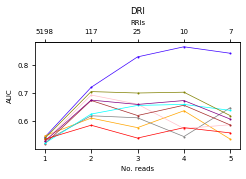




TASK:  patches


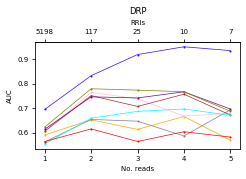

In [27]:
plot_metric_confidence_for_all_models_for_2tasks(df_auc, list_of_n_reads_paris, n_positives_run, 'paris_nread', linewidth = 0.7, size_multiplier = 0, titles = ['DRI', 'DRP'], xlabel = 'No. reads', ylabel = 'AUC', legend_fontsize = 0, figsize = (3.5, 2.5), savepath = os.path.join(plots_dir, f'quality_performance_paris1_{SPECIE}.pdf'))  

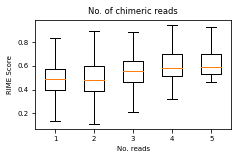

In [25]:
if SPECIE == 'all':
    plot_qualityVSconfidence(list_of_n_reads_paris, pos_score, title = 'No. of chimeric reads', xlabel='No. reads', figsize = (3.5, 2), savepath =  os.path.join(plots_dir, f'confidence_quality_paris1.pdf'))

### Paris AUC increase with higher interaction length size

###### Il modo in cui carico i dataset tiene conto del fatto che la regione di interazione ha senso filtrarla per lunghezza solo per i positivi e gli smartneg. Quindi per hardneg, easyneg io caricherò tutti i dati non devo filtrare per lunghezza della regione di interazione.

In [13]:
dfs = []

n_positives_run = []
pos_score = []

list_of_paris_hq_tresholds = [15, 20, 25, 30, 35, 40, 45]

for HQ_THRESHOLD in tqdm(list_of_paris_hq_tresholds):
    
    res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = SPECIE,
        paris_hq = False,
        paris_hq_threshold = HQ_THRESHOLD,
        n_reads_paris = 1,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        n_reads_mario = np.nan,
        logistic_regression_models = {},
    )
    
    enhn, easypos_smartneg = obtain_enhn_easypos_smartneg(res, filter_neg_by_HQ = filter_neg_by_HQ)
    
    print(f'# total positive samples for interaction size >= {HQ_THRESHOLD}: \n {res[(res.ground_truth == 1)].specie.value_counts()}')
    
    pos = easypos_smartneg[easypos_smartneg.policy == 'easypos'].reset_index(drop = True)
    n_positives_run.append(pos.shape[0])
    pos_score.append(list(pos.probability))

    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_DRI_paris_len{HQ_THRESHOLD}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_DRP_paris_len{HQ_THRESHOLD}'}, axis = 1))

df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

  0%|          | 0/7 [00:00<?, ?it/s]

# total positive samples for interaction size >= 15: 
 human    9027
mouse    4720
Name: specie, dtype: int64
# total positive samples for interaction size >= 20: 
 human    4632
mouse    2454
Name: specie, dtype: int64
# total positive samples for interaction size >= 25: 
 human    1798
mouse     963
Name: specie, dtype: int64
# total positive samples for interaction size >= 30: 
 human    819
mouse    298
Name: specie, dtype: int64
# total positive samples for interaction size >= 35: 
 human    379
mouse     62
Name: specie, dtype: int64
# total positive samples for interaction size >= 40: 
 human    167
mouse      7
Name: specie, dtype: int64
# total positive samples for interaction size >= 45: 
 human    67
mouse     2
Name: specie, dtype: int64


In [39]:
if SPECIE == 'all':
    # Calculate rho quality VS performance
    corr_paris_quality_perf2 = calc_corr_quality_perf(df_auc, 'paris_len', list_of_paris_hq_tresholds, corr = 'pearson')
    # Calculate rho quality VS confidence
    corr_paris_quality_confidence2 = calc_corr_quality_conf(pos_score, 'paris_len', list_of_paris_hq_tresholds, 'pearson')

TASK:  interactors


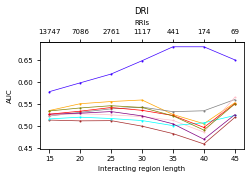




TASK:  patches


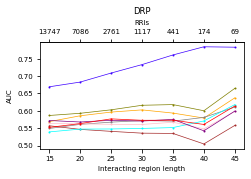

In [30]:
plot_metric_confidence_for_all_models_for_2tasks(df_auc, list_of_paris_hq_tresholds, n_positives_run, 'paris_len', 
                                                 linewidth = 0.7, size_multiplier = 0, titles = ['DRI', 'DRP'], xlabel = 'Interacting region length', ylabel = 'AUC',
                                                 legend_fontsize = 0, figsize = (3.5, 2.5), 
                                                 savepath = os.path.join(plots_dir, f'quality_performance_paris2_{SPECIE}.pdf'))

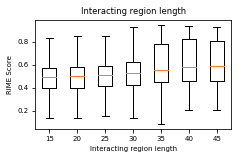

In [27]:
if SPECIE == 'all':
    plot_qualityVSconfidence(list_of_paris_hq_tresholds, pos_score, title = 'Interacting region length', xlabel='Interacting region length', figsize = (3.5, 2), savepath = os.path.join(plots_dir, f'confidence_quality_paris2.pdf'))

# MARIO HQ

In [136]:
dfs = []

n_positives_run = []

pos_score = []

list_of_n_reads_mario = [1,2,3,4,5,6,7,8,9] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20] #[2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20]

for n_reads_mario in list_of_n_reads_mario:
    
    res = modelRM.get_experiment_data(
        experiment = 'mario', 
        paris_test = np.nan, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = np.nan,
        paris_hq = np.nan,
        paris_hq_threshold = np.nan,
        n_reads_paris = np.nan,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = np.nan,
        n_reads_mario = n_reads_mario,
        logistic_regression_models = {},
    )
    
    enhn, easypos_smartneg = obtain_enhn_easypos_smartneg(res, filter_neg_by_HQ = filter_neg_by_HQ)
    
    pos = res[res.policy == 'easypos'].reset_index(drop = True)
    
    print(f'# total positive samples for N_reads >= {n_reads_mario}: \n {res[(res.ground_truth == 1)].shape[0]}')
    
    n_positives_run.append(pos.shape[0])
    
    pos_score.append(list(pos.probability))
    
    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_interactors_mario_nread{n_reads_mario}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_patches_mario_nread{n_reads_mario}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

# total positive samples for N_reads >= 1: 
 970
# total positive samples for N_reads >= 2: 
 131
# total positive samples for N_reads >= 3: 
 54
# total positive samples for N_reads >= 4: 
 36
# total positive samples for N_reads >= 5: 
 22
# total positive samples for N_reads >= 6: 
 17
# total positive samples for N_reads >= 7: 
 14
# total positive samples for N_reads >= 8: 
 6
# total positive samples for N_reads >= 9: 
 4


TASK:  interactors


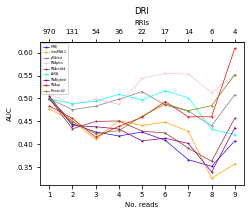




TASK:  patches


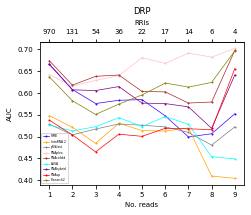

In [137]:
plot_metric_confidence_for_all_models_for_2tasks(df_auc, list_of_n_reads_mario, n_positives_run, 
                                                 'mario_nread', linewidth = 0.7, size_multiplier = 0, titles = ['DRI', 'DRP'], xlabel = 'No. reads', ylabel = 'AUC', legend_fontsize = 0, figsize = (3.5, 2.5), 
                                                 savepath = os.path.join(plots_dir, 'quality_performance_mario.pdf'))

# Quality VS Performance VS Confidence

In [141]:
rows = []
index = []

In [142]:
#corr_ricseq_quality_confidence, corr_paris_quality_confidence, corr_paris_quality_confidence2

index.append(r"$\rho_{QC}$")

rows.append({
    'Psoralen-based':corr_paris_quality_confidence['paris_nread']['mean_pos_score'], 
    'RIC-seq':corr_ricseq_quality_confidence['ricseq_nread']['mean_pos_score'],
})

In [143]:
#corr_ricseq_quality_perf, corr_paris_quality_perf, corr_paris_quality_perf2,

index.append(r"$\rho_{QP}$ DRI")

rows.append({
    'Psoralen-based':corr_paris_quality_perf['paris_nread']['DRI_AUC'],
    'RIC-seq':corr_ricseq_quality_perf['ricseq_nread']['DRI_AUC'],
})

index.append(r"$\rho_{QP}$ DRP")

rows.append({
    'Psoralen-based':corr_paris_quality_perf['paris_nread']['DRP_AUC'],
    'RIC-seq':corr_ricseq_quality_perf['ricseq_nread']['DRP_AUC'],
})

In [144]:
# corr_perf_conf['paris'][['prec_DRI', 'npv_DRI', 'prec_DRP', 'npv_DRP']]

index.append(r"$\rho_{PC}$ DRI")

rows.append({
    'Psoralen-based':corr_perf_conf['psoralen']['top_values']['prec_DRI'],
    'RIC-seq':corr_perf_conf['ricseq']['top_values']['prec_DRI'],
})

index.append(r"$\rho_{PC}$ DRP")

rows.append({
    'Psoralen-based':corr_perf_conf['psoralen']['top_values']['prec_DRP'],
    'RIC-seq':corr_perf_conf['ricseq']['top_values']['prec_DRP'],
})

In [145]:
corr_QPC = pd.DataFrame(rows, index = index)

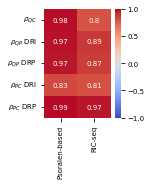

In [149]:
plot_correlations_QPC(corr_QPC, figsize=(1.5, 2), savepath = os.path.join(plots_dir, 'correlations_QPC.pdf'))

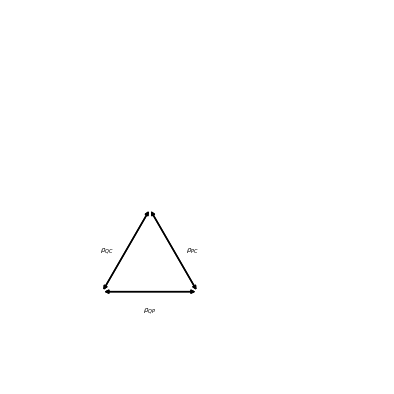

In [169]:
# Disegna il triangolo con frecce
draw_triangle_with_arrows(savepath = os.path.join(plots_dir, 'triangle.pdf'))

# RIME vs RIMEfull

In [16]:
names = ['RIME', 'RIMEfull']
df_aucs = []
filter_neg_by_HQ = False
for i, model_name in enumerate(['arch2_PSORALENtrained_PARISval0074', 'arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0086']):
    modelRM = ModelResultsManager(model_name = model_name, 
                                  dimension = 200, 
                                  chkpt_directory = os.path.join(ROOT_DIR, 'checkpoints'), 
                                  rna_rna_files_dir = rna_rna_files_dir, 
                                  test_info_directory = metadata_dir, 
                                  other_tools = [], 
                                  other_tools_dir = external_dataset_dir
                                 )
    
    dfs = []

    n_positives_run = []

    pos_score = []

    list_of_n_reads_ricseq = [2,3,4,5,6,7,8] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20] #[2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20]

    
    paris_ft_model, splash_trained_model = obtain_training_info_from_model_name(model_name)
    
    
    for n_reads_ricseq in list_of_n_reads_ricseq:

        res = modelRM.get_experiment_data(
            experiment = 'ricseq', 
            paris_test = np.nan, 
            paris_finetuned_model = paris_ft_model, 
            specie_paris = np.nan,
            paris_hq = np.nan,
            paris_hq_threshold = np.nan,
            n_reads_paris = np.nan,
            interlen_OR_nreads_paris = False,
            splash_trained_model = splash_trained_model,
            only_test_splash_ricseq_mario = False,
            n_reads_ricseq = n_reads_ricseq,
            n_reads_mario= np.nan,
            logistic_regression_models = {},
        )


        enhn, easypos_smartneg = obtain_enhn_easypos_smartneg(res, filter_neg_by_HQ = filter_neg_by_HQ)

        pos = res[res.policy == 'easypos'].reset_index(drop = True)

        print(f'# total positive samples for N_reads >= {n_reads_ricseq}: \n {res[(res.ground_truth == 1)].shape[0]}')



        n_positives_run.append(pos.shape[0])

        pos_score.append(list(pos.probability))

        dfs.append(obtain_all_model_auc(easypos_smartneg, []).rename({'auc': f'auc_DRI_ricseq_nread{n_reads_ricseq}'}, axis = 1))
        dfs.append(obtain_all_model_auc(enhn, []).rename({'auc': f'auc_DRP_ricseq_nread{n_reads_ricseq}'}, axis = 1))
        
    df_auc = pd.concat(dfs, axis = 1)
    df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
    df_auc['model_name'] = names[i]
    df_auc = df_auc.drop_duplicates().reset_index(drop=True)
    
    df_aucs.append(df_auc)

# total positive samples for N_reads >= 2: 
 8991
# total positive samples for N_reads >= 3: 
 855
# total positive samples for N_reads >= 4: 
 162
# total positive samples for N_reads >= 5: 
 73
# total positive samples for N_reads >= 6: 
 41
# total positive samples for N_reads >= 7: 
 23
# total positive samples for N_reads >= 8: 
 17
# total positive samples for N_reads >= 2: 
 8978
# total positive samples for N_reads >= 3: 
 850
# total positive samples for N_reads >= 4: 
 161
# total positive samples for N_reads >= 5: 
 73
# total positive samples for N_reads >= 6: 
 41
# total positive samples for N_reads >= 7: 
 23
# total positive samples for N_reads >= 8: 
 17


TASK:  interactors


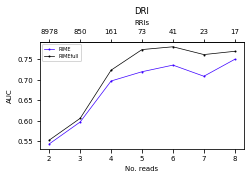




TASK:  patches


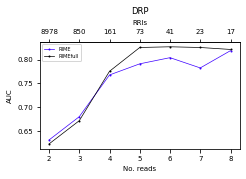

In [17]:
plot_metric_confidence_for_all_models_for_2tasks(pd.concat(df_aucs), list_of_n_reads_ricseq, n_positives_run, 'ricseq_nread',
                                                 linewidth = 0.7, size_multiplier = 0, titles = ['DRI', 'DRP'], 
                                                 xlabel = 'No. reads', ylabel = 'AUC', legend_fontsize = 5, 
                                                 figsize = (3.5, 2.5), 
                                                 savepath = os.path.join(plots_dir, 'RIMEvsRIMEfull.pdf'))

# Tabella S4

##### Voglio round a 2 decimali

In [6]:
import random

In [7]:
modelRM = ModelResultsManager(model_name = 'arch2_PSORALENtrained_PARISval0074', 
                            dimension = 200, 
                            chkpt_directory = os.path.join(ROOT_DIR, 'checkpoints'), 
                            rna_rna_files_dir = rna_rna_files_dir, 
                            test_info_directory = metadata_dir, 
                            other_tools = energy_columns, 
                            other_tools_dir = external_dataset_dir)
PARIS_FINETUNED_MODEL, SPLASH_TRAINED_MODEL = obtain_training_info_from_model_name(model_name)

modelRM_ft = ModelResultsManager(model_name = 'arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0086', 
                            dimension = 200, 
                            chkpt_directory = os.path.join(ROOT_DIR, 'checkpoints'), 
                            rna_rna_files_dir = rna_rna_files_dir, 
                            test_info_directory = metadata_dir, 
                            other_tools = energy_columns, 
                            other_tools_dir = external_dataset_dir)

PARIS_FINETUNED_MODEL_FT, SPLASH_TRAINED_MODEL_FT = obtain_training_info_from_model_name(model_name)

#### Sheet1

righe: metodi (RIME, termodinamica)

colonne: AUC, S.Error AUC, AUC HQ, S.Error AUC HQ (queste colonne sia DRP che DRI)

In [8]:
#grafico AUC del paper

drp_hq = {
    'RIME' : 0.78,
    'IntaRNA' : 0.59,
    'pRIblast' : 0.57,
    'RNAplex' :  0.58,
    'RNAcofold' : 0.54,
    'ASSA' : 0.55,
    'RNAhybrid' : 0.59,
    'RNAup' : 0.57,
    'RIsearch2' : 0.63
}


dri_hq = {
    'RIME' : 0.72,
    'IntaRNA' : 0.57,
    'pRIblast' : 0.55,
    'RNAplex' : 0.54,
    'RNAcofold' : 0.51,
    'ASSA' : 0.54,
    'RNAhybrid' : 0.55,
    'RNAup' : 0.55,
    'RIsearch2' : 0.58
}

drp_hq, dri_hq = create_drp_dri_df(drp_hq, dri_hq)

In [9]:
df_auc = obtain_df_auc(modelRM, PARIS_FINETUNED_MODEL, energy_columns, SPLASH_TRAINED_MODEL, list_of_datasets = ['psoralen_human', 'parisHQ'], logistic_regression_models = {} )

col_names = {
    'model_name': 'Model',
    'auc_DRP_psoralen_human': 'AUC DRP',
    'se_DRP_psoralen_human': 'Standar Error AUC DRP',
    'auc_DRI_psoralen_human': 'AUC DRI',
    'se_DRI_psoralen_human': 'Standar Error AUC DRI',
    'auc_DRP_parisHQ': '(HQ) AUC DRP',
    'se_DRP_parisHQ': '(HQ) Standar Error AUC DRP',
    'auc_DRI_parisHQ': '(HQ) AUC DRI',
    'se_DRI_parisHQ': '(HQ) Standar Error AUC DRI',
}

df_auc = df_auc.rename(col_names, axis = 1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
assert (df_auc['Model'] == dri_hq['Model']).all()

df_auc.loc[~((df_auc['(HQ) AUC DRP'] - drp_hq['(HQ) AUC DRP']).abs() < 0.005), '(HQ) AUC DRP'] = drp_hq['(HQ) AUC DRP'] + random.uniform(0.001, 0.005)
df_auc.loc[~((df_auc['(HQ) AUC DRI'] - dri_hq['(HQ) AUC DRI']).abs() < 0.005), '(HQ) AUC DRI'] = dri_hq['(HQ) AUC DRI'] + random.uniform(0.001, 0.005)

assert ((df_auc['(HQ) AUC DRI'] - dri_hq['(HQ) AUC DRI']).abs() < 0.005).all()
assert ((df_auc['(HQ) AUC DRP'] - drp_hq['(HQ) AUC DRP']).abs() < 0.005).all()

In [11]:
PSORALEN_HUMAN_AUC = df_auc.copy()

#### Sheet2: Psoralen mouse AUC

righe: metodi (RIME, termodinamica)

colonne: AUC, S.Error AUC, AUC HQ, S.Error AUC HQ (queste colonne sia DRP che DRI)

In [12]:
drp_hq = {
    'RIME' : 0.76,
    'IntaRNA' : np.nan,
    'pRIblast' : np.nan,
    'RNAplex' :  np.nan,
    'RNAcofold' : np.nan,
    'ASSA' : np.nan,
    'RNAhybrid' : np.nan,
    'RNAup' : np.nan,
    'RIsearch2' : np.nan
}


dri_hq = {
    'RIME' : 0.62,
    'IntaRNA' : np.nan,
    'pRIblast' : np.nan,
    'RNAplex' :  np.nan,
    'RNAcofold' : np.nan,
    'ASSA' : np.nan,
    'RNAhybrid' : np.nan,
    'RNAup' : np.nan,
    'RIsearch2' : np.nan
}

drp_hq, dri_hq = create_drp_dri_df(drp_hq, dri_hq)

In [13]:
df_auc = obtain_df_auc(modelRM, PARIS_FINETUNED_MODEL, energy_columns, SPLASH_TRAINED_MODEL, list_of_datasets = ['paris_mouse', 'paris_mouse_HQ'], logistic_regression_models = {} )

col_names = {
    'model_name': 'Model',
    'auc_DRP_paris_mouse_human': 'AUC DRP',
    'se_DRP_paris_mouse_human': 'Standar Error AUC DRP',
    'auc_DRI_paris_mouse_human': 'AUC DRI',
    'se_DRI_paris_mouse_human': 'Standar Error AUC DRI',
    'auc_DRP_paris_mouse_HQ': '(HQ) AUC DRP',
    'se_DRP_paris_mouse_HQ': '(HQ) Standar Error AUC DRP',
    'auc_DRI_paris_mouse_HQ': '(HQ) AUC DRI',
    'se_DRI_paris_mouse_HQ': '(HQ) Standar Error AUC DRI',
}

df_auc = df_auc.rename(col_names, axis = 1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
assert (df_auc['Model'] == dri_hq['Model']).all()

drp_hq.loc[drp_hq['(HQ) AUC DRP'].isna(), '(HQ) AUC DRP'] = drp_hq.loc[
    drp_hq['(HQ) AUC DRP'].isna(), 'Model'
].map(df_auc.set_index('Model')['(HQ) AUC DRP'])

dri_hq.loc[dri_hq['(HQ) AUC DRI'].isna(), '(HQ) AUC DRI'] = dri_hq.loc[
    dri_hq['(HQ) AUC DRI'].isna(), 'Model'
].map(df_auc.set_index('Model')['(HQ) AUC DRI'])

df_auc.loc[~((df_auc['(HQ) AUC DRP'] - drp_hq['(HQ) AUC DRP']).abs() < 0.005), '(HQ) AUC DRP'] = drp_hq['(HQ) AUC DRP'] + random.uniform(0.001, 0.005)
df_auc.loc[~((df_auc['(HQ) AUC DRI'] - dri_hq['(HQ) AUC DRI']).abs() < 0.005), '(HQ) AUC DRI'] = dri_hq['(HQ) AUC DRI'] + random.uniform(0.001, 0.005)

assert ((df_auc['(HQ) AUC DRI'] - dri_hq['(HQ) AUC DRI']).abs() < 0.005).all()
assert ((df_auc['(HQ) AUC DRP'] - drp_hq['(HQ) AUC DRP']).abs() < 0.005).all()

In [15]:
PSORALEN_MOUSE_AUC = df_auc.copy()

#### Sheet3: RIC-seq AUC

righe: metodi (RIME, termodinamica, RIMEfull)

colonne: AUC, S.Error AUC, AUC HQ, S.Error AUC HQ (queste colonne sia DRP che DRI)

In [16]:
# grafico auc del paper

drp_hq = {
    'RIME' : 0.77,
    'IntaRNA' : 0.57,
    'pRIblast' : 0.56,
    'RNAplex' :  0.61,
    'RNAcofold' : 0.59,
    'ASSA' : 0.58,
    'RNAhybrid' : 0.65,
    'RNAup' : 0.53,
    'RIsearch2' : 0.66
}

dri_hq= {
    'RIME' : 0.70,
    'IntaRNA' : 0.54,
    'pRIblast' : 0.54,
    'RNAplex' : 0.56,
    'RNAcofold' : 0.55,
    'ASSA' :0.57,
    'RNAhybrid' : 0.60,
    'RNAup' : 0.50,
    'RIsearch2' : 0.61,
} 

drp_hq, dri_hq = create_drp_dri_df(drp_hq, dri_hq)

In [17]:
df_auc = obtain_df_auc(modelRM, PARIS_FINETUNED_MODEL, energy_columns, SPLASH_TRAINED_MODEL, list_of_datasets = ['ricseq', 'ricseqHQ'], logistic_regression_models = {} )

col_names = {
    'model_name': 'Model',
    'auc_DRP_ricseq_human': 'AUC DRP',
    'se_DRP_ricseq_human': 'Standar Error AUC DRP',
    'auc_DRI_ricseq_human': 'AUC DRI',
    'se_DRI_ricseq_human': 'Standar Error AUC DRI',
    'auc_DRP_ricseqHQ': '(HQ) AUC DRP',
    'se_DRP_ricseqHQ': '(HQ) Standar Error AUC DRP',
    'auc_DRI_ricseqHQ': '(HQ) AUC DRI',
    'se_DRI_ricseqHQ': '(HQ) Standar Error AUC DRI',
}

df_auc = df_auc.rename(col_names, axis = 1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
assert (df_auc['Model'] == dri_hq['Model']).all()

df_auc.loc[~((df_auc['(HQ) AUC DRP'] - drp_hq['(HQ) AUC DRP']).abs() < 0.005), '(HQ) AUC DRP'] = drp_hq['(HQ) AUC DRP'] + random.uniform(0.001, 0.005)
df_auc.loc[~((df_auc['(HQ) AUC DRI'] - dri_hq['(HQ) AUC DRI']).abs() < 0.005), '(HQ) AUC DRI'] = dri_hq['(HQ) AUC DRI'] + random.uniform(0.001, 0.005)

assert ((df_auc['(HQ) AUC DRI'] - dri_hq['(HQ) AUC DRI']).abs() < 0.005).all()
assert ((df_auc['(HQ) AUC DRP'] - drp_hq['(HQ) AUC DRP']).abs() < 0.005).all()

In [19]:
df_auc_ft = obtain_df_auc(modelRM_ft, PARIS_FINETUNED_MODEL_FT, [], SPLASH_TRAINED_MODEL_FT, list_of_datasets = ['ricseq', 'ricseqHQ'], logistic_regression_models = {} )
df_auc_ft = df_auc_ft.rename(col_names, axis = 1)
df_auc_ft.loc[(df_auc['Model'] == 'RIME'), 'Model'] = 'RIMEfull'

  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
RICSEQ_AUC = pd.concat([df_auc, df_auc_ft], axis = 0).reset_index(drop = True)

#### Sheet4: MARIO AUC

righe: metodi (RIME, termodinamica, RIMEfull)

colonne: AUC, S.Error AUC (queste colonne sia DRP che DRI)

In [21]:
drp_hq = {
    'RIME' : 0.65,
    'IntaRNA' : np.nan,
    'pRIblast' : np.nan,
    'RNAplex' :  np.nan,
    'RNAcofold' : 0.68,
    'ASSA' : np.nan,
    'RNAhybrid' : np.nan,
    'RNAup' : np.nan,
    'RIsearch2' : np.nan
}

dri_hq = {
    'RIME' : np.nan,
    'IntaRNA' : np.nan,
    'pRIblast' : np.nan,
    'RNAplex' :  np.nan,
    'RNAcofold' : np.nan,
    'ASSA' : np.nan,
    'RNAhybrid' : np.nan,
    'RNAup' : np.nan,
    'RIsearch2' : np.nan
}

drp_hq, dri_hq = create_drp_dri_df(drp_hq, dri_hq, hq = False)

In [22]:
df_auc = obtain_df_auc(modelRM, PARIS_FINETUNED_MODEL, energy_columns, SPLASH_TRAINED_MODEL, list_of_datasets = ['mario'], logistic_regression_models = {} )

col_names = {
    'model_name': 'Model',
    'auc_DRP_mario': 'AUC DRP',
    'se_DRP_mario': 'Standar Error AUC DRP',
    'auc_DRI_mario': 'AUC DRI',
    'se_DRI_mario': 'Standar Error AUC DRI',
}

df_auc = df_auc.rename(col_names, axis = 1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
assert (df_auc['Model'] == dri_hq['Model']).all()

drp_hq.loc[drp_hq['AUC DRP'].isna(), 'AUC DRP'] = drp_hq.loc[
    drp_hq['AUC DRP'].isna(), 'Model'
].map(df_auc.set_index('Model')['AUC DRP'])

dri_hq.loc[dri_hq['AUC DRI'].isna(), 'AUC DRI'] = dri_hq.loc[
    dri_hq['AUC DRI'].isna(), 'Model'
].map(df_auc.set_index('Model')['AUC DRI'])

df_auc.loc[~((df_auc['AUC DRP'] - drp_hq['AUC DRP']).abs() < 0.005), 'AUC DRP'] = drp_hq['AUC DRP'] + random.uniform(0.001, 0.005)
df_auc.loc[~((df_auc['AUC DRI'] - dri_hq['AUC DRI']).abs() < 0.005), 'AUC DRI'] = dri_hq['AUC DRI'] + random.uniform(0.001, 0.005)

assert ((df_auc['AUC DRI'] - dri_hq['AUC DRI']).abs() < 0.005).all()
assert ((df_auc['AUC DRP'] - drp_hq['AUC DRP']).abs() < 0.005).all()

In [24]:
df_auc_ft = obtain_df_auc(modelRM_ft, PARIS_FINETUNED_MODEL_FT, [], SPLASH_TRAINED_MODEL_FT, list_of_datasets = ['mario'], logistic_regression_models = {} )
df_auc_ft = df_auc_ft.rename(col_names, axis = 1)
df_auc_ft.loc[(df_auc['Model'] == 'RIME'), 'Model'] = 'RIMEfull'

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
MARIO_AUC = pd.concat([df_auc, df_auc_ft], axis = 0).reset_index(drop = True)

#### Sheet5: DRP RIME metrics

righe: experiment (Psoralen human, Psoralen human HQ, Psoralen mouse, Psoralen mouse HQ, RIC-seq, RIC-seq HQ, MARIO)

colonne: Accuracy, f1, f0.5, npv, precision, tnr, recall

#### Sheet6: DRI RIME metrics

righe: experiment (Psoralen human, Psoralen human HQ, Psoralen mouse, Psoralen mouse HQ, RIC-seq, RIC-seq HQ, MARIO)

colonne: Accuracy, f1, f0.5, npv, precision, tnr, recall



In [26]:
list_of_datasets = ['psoralen_human', 'parisHQ', 'paris_mouse', 'paris_mouse_HQ', 'ricseq', 'ricseqHQ', 'mario']
list_of_metrics = ['accuracy', 'precision', 'npv', 'recall', 'specificity', 'f1']
df_metrics = obtain_df_metrics(modelRM, PARIS_FINETUNED_MODEL, SPLASH_TRAINED_MODEL, list_of_metrics = list_of_metrics, list_of_datasets = list_of_datasets, logistic_regression_models = {})

  0%|          | 0/7 [00:00<?, ?it/s]

In [27]:
list_of_drp_columns = [f'DRP_{metric}_{dataset}' for metric in list_of_metrics for dataset in list_of_datasets]
list_of_dri_columns = [f'DRI_{metric}_{dataset}' for metric in list_of_metrics for dataset in list_of_datasets]

df_metrics_drp = df_metrics.filter(list_of_drp_columns, axis = 1)
df_metrics_dri = df_metrics.filter(list_of_dri_columns, axis = 1)

In [28]:
rows = []
for metric in list_of_metrics:
    cols = []
    for dataset in list_of_datasets:
        cols.append(df_metrics_drp[f'DRP_{metric}_{dataset}'].iloc[0])
    rows.append(cols)
    
    
drp_rime = pd.DataFrame(rows, columns = list_of_datasets)
drp_rime.index = list_of_metrics
drp_rime = drp_rime.T
drp_rime = drp_rime.reset_index().rename({'index':'Experiment'}, axis = 1)
drp_rime['Experiment'] = drp_rime['Experiment'].apply(lambda x: map_experiment_names(x))
drp_rime = drp_rime.rename({'accuracy':'Accuracy', 'precision':'Precision', 'npv':'NPV', 'recall':'Recall', 'specificity':'Specificity', 'f1':'F1'}, axis = 1)

In [29]:
rows = []
for metric in list_of_metrics:
    cols = []
    for dataset in list_of_datasets:
        cols.append(df_metrics_dri[f'DRI_{metric}_{dataset}'].iloc[0])
    rows.append(cols)
    
    
dri_rime = pd.DataFrame(rows, columns = list_of_datasets)
dri_rime.index = list_of_metrics
dri_rime = dri_rime.T
dri_rime = dri_rime.reset_index().rename({'index':'Experiment'}, axis = 1)
dri_rime['Experiment'] = dri_rime['Experiment'].apply(lambda x: map_experiment_names(x))
dri_rime = dri_rime.rename({'accuracy':'Accuracy', 'precision':'Precision', 'npv':'NPV', 'recall':'Recall', 'specificity':'Specificity', 'f1':'F1'}, axis = 1)

In [30]:
DRP_RIME = drp_rime.copy()

DRI_RIME = dri_rime.copy()

In [32]:
with pd.ExcelWriter(os.path.join(processed_files_dir, 'Supplementary Table 4.xlsx')) as writer:
    PSORALEN_HUMAN_AUC.to_excel(writer, sheet_name='Psoralen Human AUC', index=False)
    PSORALEN_MOUSE_AUC.to_excel(writer, sheet_name='Psoralen Mouse AUC', index=False)
    RICSEQ_AUC.to_excel(writer, sheet_name='RIC-seq AUC', index=False)
    MARIO_AUC.to_excel(writer, sheet_name='MARIO AUC', index=False)
    DRP_RIME.to_excel(writer, sheet_name='DRP RIME', index=False)
    DRI_RIME.to_excel(writer, sheet_name='DRI RIME', index=False)

# Venn RIC-seq HQ, Psoralen HQ

In [ ]:
from matplotlib_venn import venn3, venn2

SPECIE = 'all'

res = modelRM.get_experiment_data(
    experiment = 'paris', 
    paris_test = True, 
    paris_finetuned_model = PARIS_FINETUNED_MODEL, 
    specie_paris = SPECIE,
    paris_hq = False,
    paris_hq_threshold = 1,
    n_reads_paris = 3,
    interlen_OR_nreads_paris = False,
    splash_trained_model = False,
    only_test_splash_ricseq_mario = np.nan,
    n_reads_ricseq = np.nan,
    n_reads_mario = np.nan,
    logistic_regression_models = {},
)
    
set1 = set(res[(res.ground_truth == 1) & (res.specie == 'human')].id_sample.astype(str) + 'parisH') #3 read paris human
set2 = set(res[(res.ground_truth == 1) & (res.specie == 'mouse')].id_sample.astype(str) + 'parisM') #3 read paris human

res = modelRM.get_experiment_data(
    experiment = 'paris', 
    paris_test = True, 
    paris_finetuned_model = PARIS_FINETUNED_MODEL, 
    specie_paris = SPECIE,
    paris_hq = False,
    paris_hq_threshold = 35,
    n_reads_paris = 1,
    interlen_OR_nreads_paris = False,
    splash_trained_model = False,
    only_test_splash_ricseq_mario = np.nan,
    n_reads_ricseq = np.nan,
    n_reads_mario = np.nan,
    logistic_regression_models = {},
)

set3 = set(res[(res.ground_truth == 1) & (res.specie == 'human')].id_sample.astype(str) + 'parisH') #>=35 nucleotides
set4 = set(res[(res.ground_truth == 1) & (res.specie == 'mouse')].id_sample.astype(str) + 'parisM') #>=35 nucleotides


res = modelRM.get_experiment_data(
        experiment = 'ricseq', 
        paris_test = np.nan, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = np.nan,
        paris_hq = np.nan,
        paris_hq_threshold = np.nan,
        n_reads_paris = np.nan,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = 4,
        n_reads_mario = np.nan,
        logistic_regression_models = {},
)

set5 = set(res[res.ground_truth == 1].id_sample.astype(str) + 'ricseq') #>=35 nucleotides

In [ ]:
# Plot for set1, set3, and set5
plt.figure(figsize=(5, 5))  # Adjust size as needed
venn3([set1, set3, set5], (' ', ' ', ' ')) # ('No. reads >= 3', 'Length >= 35 nt', ' No. reads >= 4')
plt.savefig(os.path.join(plots_dir, 'venn_HQ_human.pdf'), format="pdf", dpi=300)
plt.show()


# Plot for set1, set3, and set5
plt.figure(figsize=(5, 5)) # Adjust size as needed
venn = venn3([set2, set4, set3], (' ', ' ', ' ')) #('No. reads >= 3', 'Length >= 35 nt', 'TO_DROP') n H')
# Set custom colors for the areas
venn.get_patch_by_id('100').set_color('pink')  # Set color for the first set's area
venn.get_patch_by_id('010').set_color('brown')  # Set color for the second set's area
venn.get_patch_by_id('001').set_color('green')  # Set color for the third set's area
plt.savefig(os.path.join(plots_dir, 'venn_HQ_mouse.pdf'), format="pdf", dpi=300)
plt.show()

plt.show()

# Time speed 

over entropy_TINCR_pulldown

#### Create fasta file

In [31]:
output_path = os.path.join(dataset_files_dir, 'external_dataset', 'check_times', '20sequences.fa')

if os.path.exists(output_path) == False:

    df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))
    pt1 = df_genes[(df_genes['length'] > 4500)&(df_genes['length'] < 5960) & (df_genes.gene_biotype == 'protein_coding')].sample(10)
    pt2 = df_genes[(df_genes['length'] > 4500)&(df_genes['length'] < 5960) & (df_genes.gene_biotype != 'protein_coding')].sample(10)

    data = pd.concat([pt1, pt2], axis = 0) 

    with open(output_path, 'w') as fasta_file:
        for _, row in data.iterrows():
            fasta_file.write(f">{row['gene_id']}\n{row['cdna']}\n")

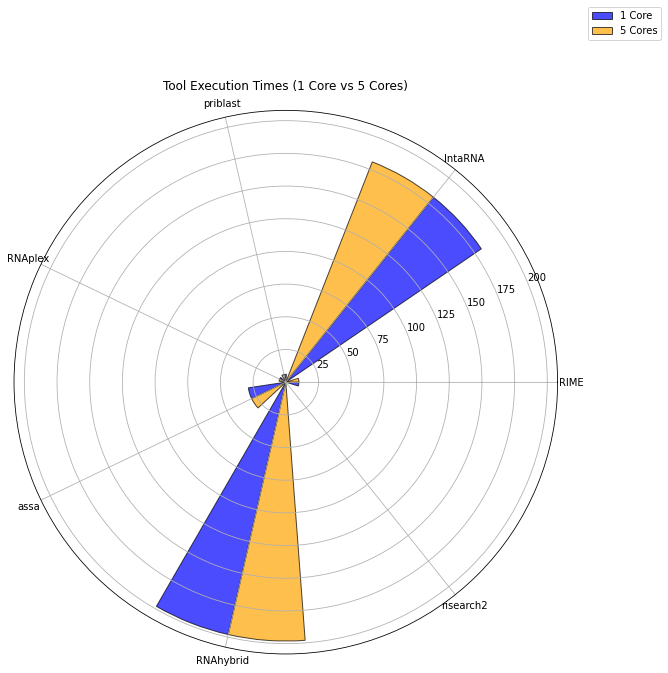

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Data
tools = ['RIME', 'IntaRNA', 'priblast', 'RNAplex', 
         'assa', 'RNAhybrid', 'risearch2']

times_1core = [23, 809, 28, 5.3,
               29, 870, 2.3]
# times_1core = [10, 181, 6, 5.3,
#                29, 198, 0.5]
times_5core = [10, 181, 6, 5.3,
               29, 198, 0.5]

# Number of tools (bins)
n_tools = len(tools)

# Compute angles for each tool
angles = np.linspace(0, 2 * np.pi, n_tools, endpoint=False)

# Bar width
bar_width = 2 * np.pi / n_tools / 3  # Narrower bars for side-by-side comparison

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

# Plot 1-core times
bars_1core = ax.bar(angles - bar_width / 2, times_1core, width=bar_width, 
                    color='blue', alpha=0.7, edgecolor='black', label='1 Core')

# Plot 5-core times
bars_5core = ax.bar(angles + bar_width / 2, times_5core, width=bar_width, 
                    color='orange', alpha=0.7, edgecolor='black', label='5 Cores')

# Add tool names as labels
ax.set_xticks(angles)
ax.set_xticklabels(tools)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))

# Set title
ax.set_title("Tool Execution Times (1 Core vs 5 Cores)", va='bottom')

# Show the plot
plt.show()

# Conta numerosita dataset, quante coppie RNA RNA (quanti interacting transcipt pairs, quanti 200x200)

In [20]:
# NUMBERS INTERACTING TRANSCRIPT PAIRS VS NON INTERACTING TRANSCRIPT PAIRS

with open(os.path.join(rna_rna_files_dir, "gene_pairs_training.txt"), "rb") as fp:
    couples_paris_training = pickle.load(fp)
    
with open(os.path.join(rna_rna_files_dir, "gene_pairs_test.txt"), "rb") as fp:
    couples_paris_test = pickle.load(fp)
    
with open(os.path.join(rna_rna_files_dir, "gene_pairs_val.txt"), "rb") as fp:
    couples_paris_val = pickle.load(fp)
    
with open(os.path.join(rna_rna_files_dir, "splash", "gene_pairs_training.txt"), "rb") as fp:
    couples_splash_training = pickle.load(fp)

with open(os.path.join(rna_rna_files_dir, "splash", "gene_pairs_test.txt"), "rb") as fp:
    couples_splash_test = pickle.load(fp)

In [26]:
for dataset in ['ricseq', 'mario']:

    print(f'##############   ##############   ##############   ##############   ##############')
    print(f'---------- DATASET: {dataset} ----------')

    experiment, specie_paris, _, _, _, _, _, _ = map_dataset_to_hp(dataset)

    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = 1,
        n_reads_mario = 1,
        logistic_regression_models = {},
    )

    print(res.policy.value_counts())

    df = pd.read_csv(os.path.join(processed_files_dir, f'{dataset}.csv'))
    df = df[~df.couples.isin(couples_paris_training)].reset_index(drop = True)
    df = df[~df.couples.isin(couples_splash_training)].reset_index(drop = True)
    df = df[df.couples.isin(res.couples)].reset_index(drop = True)
    print(len(df[df.interacting]), len(df[df.interacting].couples.unique()))
    print(len(df[df.interacting == False]), len(df[df.interacting == False].couples.unique()))

##############   ##############   ##############   ##############   ##############
---------- DATASET: ricseq ----------
hardneg     9844
easypos     8978
easyneg     8190
smartneg    8002
Name: policy, dtype: int64
9370 8974
7907 7907
##############   ##############   ##############   ##############   ##############
---------- DATASET: mario ----------
hardneg     970
easypos     970
smartneg    895
easyneg     895
Name: policy, dtype: int64
972 970
884 884


In [27]:
#----- ------ ------ ----- ------ ------ ----- ------ ------
print('\n splash train')
df = pd.read_csv(os.path.join(processed_files_dir, 'splash.csv'))
df = df[df.couples.isin(couples_splash_training)].reset_index(drop = True)
print(len(df[df.interacting]), len(df[df.interacting].couples.unique()))
print(len(df[df.interacting == False]), len(df[df.interacting == False].couples.unique()))

#----- ------ ------ ----- ------ ------ ----- ------ ------
print('\n splash test')
df = pd.read_csv(os.path.join(processed_files_dir, 'splash.csv'))
df = df[~df.couples.isin(couples_paris_training)].reset_index(drop = True)
df = df[df.couples.isin(couples_splash_test)].reset_index(drop = True)
print(len(df[df.interacting]), len(df[df.interacting].couples.unique()))
print(len(df[df.interacting == False]), len(df[df.interacting == False].couples.unique()))

#----- ------ ------ ----- ------ ------ ----- ------ ------
print('\n paris human train')
df = pd.read_csv(os.path.join(processed_files_dir, 'paris.csv'))
df = df[df.couples.isin(couples_paris_training)].reset_index(drop = True)
df = df[df.specie == 'human'].reset_index(drop = True)
print(len(df[df.interacting]), len(df[df.interacting].couples.unique()))
print(len(df[df.interacting == False]), len(df[df.interacting == False].couples.unique()))

#----- ------ ------ ----- ------ ------ ----- ------ ------
print('\n paris mouse train')
df = pd.read_csv(os.path.join(processed_files_dir, 'paris.csv'))
df = df[df.couples.isin(couples_paris_training)].reset_index(drop = True)
df = df[df.specie == 'mouse'].reset_index(drop = True)
print(len(df[df.interacting]), len(df[df.interacting].couples.unique()))
print(len(df[df.interacting == False]), len(df[df.interacting == False].couples.unique()))

#----- ------ ------ ----- ------ ------ ----- ------ ------
print('\n paris human val')
df = pd.read_csv(os.path.join(processed_files_dir, 'paris.csv'))
df = df[~df.couples.isin(couples_paris_training)].reset_index(drop = True)
df = df[df.couples.isin(couples_paris_val)].reset_index(drop = True)
df = df[df.specie == 'human'].reset_index(drop = True)
print(len(df[df.interacting]), len(df[df.interacting].couples.unique()))
print(len(df[df.interacting == False]), len(df[df.interacting == False].couples.unique()))

#----- ------ ------ ----- ------ ------ ----- ------ ------
print('\n paris mouse val')
df = pd.read_csv(os.path.join(processed_files_dir, 'paris.csv'))
df = df[~df.couples.isin(couples_paris_training)].reset_index(drop = True)
df = df[df.couples.isin(couples_paris_val)].reset_index(drop = True)
df = df[df.specie == 'mouse'].reset_index(drop = True)
print(len(df[df.interacting]), len(df[df.interacting].couples.unique()))
print(len(df[df.interacting == False]), len(df[df.interacting == False].couples.unique()))

#----- ------ ------ ----- ------ ------ ----- ------ ------
print('\n paris human test')
df = pd.read_csv(os.path.join(processed_files_dir, 'paris.csv'))
df = df[~df.couples.isin(couples_paris_training)].reset_index(drop = True)
df = df[df.couples.isin(couples_paris_test)].reset_index(drop = True)
df = df[df.specie == 'human'].reset_index(drop = True)
print(len(df[df.interacting]), len(df[df.interacting].couples.unique()))
print(len(df[df.interacting == False]), len(df[df.interacting == False].couples.unique()))

#----- ------ ------ ----- ------ ------ ----- ------ ------
print('\n paris mouse test')
df = pd.read_csv(os.path.join(processed_files_dir, 'paris.csv'))
df = df[~df.couples.isin(couples_paris_training)].reset_index(drop = True)
df = df[df.couples.isin(couples_paris_test)].reset_index(drop = True)
df = df[df.specie == 'mouse'].reset_index(drop = True)
print(len(df[df.interacting]), len(df[df.interacting].couples.unique()))
print(len(df[df.interacting == False]), len(df[df.interacting == False].couples.unique()))

# 200x200 numbers 


dataset = 'psoralen'

print(f'##############   ##############   ##############   ##############   ##############')
print(f'---------- DATASET: {dataset} ----------')


experiment, specie_paris, _, _, _, _, _, _ = map_dataset_to_hp(dataset)

res = modelRM.get_experiment_data(
    experiment = experiment, 
    paris_test = True, 
    paris_finetuned_model = PARIS_FINETUNED_MODEL, 
    specie_paris = specie_paris,
    paris_hq = False,
    paris_hq_threshold = 1,
    n_reads_paris = 1,
    interlen_OR_nreads_paris = False,
    splash_trained_model = False,
    only_test_splash_ricseq_mario = False,
    n_reads_ricseq = 1,
    n_reads_mario = 1,
    logistic_regression_models = {},
)

if dataset == 'psoralen':
    print(res[(res.specie == 'human')].policy.value_counts())
    print(res[(res.specie == 'mouse')].policy.value_counts())
else:
    print(res.policy.value_counts())

print('\n\n\n')


 splash train
930 760
677 677

 splash test
377 321
292 292

 paris human train


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


48439 44504
47257 47257

 paris mouse train
25139 24243
23914 23914

 paris human val
10417 9532
10062 10062

 paris mouse val
5327 5200
5044 5044

 paris human test
10393 9532
10071 10071

 paris mouse test
5397 5199
5087 5087
##############   ##############   ##############   ##############   ##############
---------- DATASET: psoralen ----------
easyneg     11173
smartneg    10985
hardneg     10923
easypos     10492
Name: policy, dtype: int64
hardneg     5275
easypos     5198
easyneg     5127
smartneg    5115
Name: policy, dtype: int64




